In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm
import time

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Data Raihan\Penelitian Threshold\\Dataset\\APIsecurityAccessbehavoranomalydataset\\supervised_dataset.csv") #DM--> Dataset Malware

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1699 non-null   int64  
 1   _id                             1699 non-null   object 
 2   inter_api_access_duration(sec)  1695 non-null   float64
 3   api_access_uniqueness           1695 non-null   float64
 4   sequence_length(count)          1699 non-null   float64
 5   vsession_duration(min)          1699 non-null   int64  
 6   ip_type                         1699 non-null   object 
 7   num_sessions                    1699 non-null   float64
 8   num_users                       1699 non-null   float64
 9   num_unique_apis                 1699 non-null   float64
 10  source                          1699 non-null   object 
 11  classification                  1699 non-null   object 
dtypes: float64(6), int64(2), object(4)

In [4]:
#Feature Selection
X = DM.drop(['Unnamed: 0','_id','source', 'ip_type', 'classification'],axis=1).values    #Droping this because classification model will not accept object type elements (float and int only)
# Target variable
y = DM['classification'].values

In [5]:
#Remove Nan
X = pd.DataFrame(X).dropna()
y = y[X.index]

In [6]:
#Data Fitting and choosing the important variables
extratrees = ek.ExtraTreesClassifier().fit(X,y)
model = SelectFromModel(extratrees, prefit=True)
X_new = model.transform(X)
nbfeatures = X_new.shape[1]

In [7]:
features = []
index = numpy.argsort(extratrees.feature_importances_)[::-1][:nbfeatures]

In [8]:
#All the required features
for f in range(nbfeatures):
    print("%d. feature %s (%f)" % (f + 1, DM.columns[2+index[f]], extratrees.feature_importances_[index[f]]))
    features.append(DM.columns[2+f])

1. feature api_access_uniqueness (0.478603)
2. feature num_sessions (0.231822)


In [9]:
# Memilih 10% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('classification').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)

In [10]:
hasil_threshold = []

def Thresholding(threshold, feature):
    # Mulai perhitungan waktu
    start_time = time.time()

    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # Menentukan TP, TN, FP, FN
    from sklearn.metrics import confusion_matrix

    # Untuk BenignDataThreshold
    y_true_benign = ["normal"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["classification"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["outlier"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["classification"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp/(tp+fp) if (tp+fp) != 0 else 0
    RecallThreshold = tp/(tp+fn) if (tp+fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold*RecallThreshold)/(PrecisionThreshold+RecallThreshold)) if (PrecisionThreshold+RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp+tn)/(tp+fp+tn+fn) if (tp+fp+tn+fn) != 0 else 0

    # Akhir perhitungan waktu
    end_time = time.time()
    running_time = end_time - start_time

    # Menyimpan hasil ke list
    matrix = [[feature, threshold], [PrecisionThreshold], [RecallThreshold], [F1ScoreThreshold], [AccuracyThreshold], [running_time]]
    hasil_threshold.append(matrix)

for feature in tqdm(features, desc='Progress'):
    Max = sampled_data[feature].max()
    Min = sampled_data[feature].min()

    for x in range(int(Min), int(Max + 1)):
        Thresholding(x, feature)

print(hasil_threshold)


Progress: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.92s/it]

[[['inter_api_access_duration(sec)', 0], [0.0], [0], [0], [0.6525073746312684], [0.014451026916503906]], [['inter_api_access_duration(sec)', 1], [0.7606112054329371], [0.2882882882882883], [0.41810545963602425], [0.26430678466076696], [0.013119697570800781]], [['inter_api_access_duration(sec)', 2], [0.8149405772495756], [0.3026481715006305], [0.4413793103448276], [0.2831858407079646], [0.011147260665893555]], [['inter_api_access_duration(sec)', 3], [0.8590831918505942], [0.31389578163771714], [0.4597910040890505], [0.2985250737463127], [0.010422229766845703]], [['inter_api_access_duration(sec)', 4], [0.8845500848896435], [0.32022126613398894], [0.47021660649819497], [0.30737463126843656], [0.012515783309936523]], [['inter_api_access_duration(sec)', 5], [0.8930390492359932], [0.32230392156862747], [0.4736605132823053], [0.31032448377581123], [0.009813785552978516]], [['inter_api_access_duration(sec)', 6], [0.9049235993208828], [0.32519829164124464], [0.4784560143626571], [0.314454277286

In [11]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = [['', 0], [0], [0], [0], [0], [0]]
winner_recall = [['', 0], [0], [0], [0], [0], [0]]
winner_f1_score = [['', 0], [0], [0], [0], [0], [0]]
winner_accuracy = [['', 0], [0], [0], [0], [0], [0]]
winner_run_time = [['', 0], [0], [0], [0], [0], [float('inf')]]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

for result in hasil_threshold:
    # Membandingkan Precision
    if result[1][0] > winner_precision[1][0]:
        winner_precision = result
    
    # Membandingkan Recall
    if result[2][0] > winner_recall[2][0]:
        winner_recall = result

    # Membandingkan F1-score
    if result[3][0] > winner_f1_score[3][0]:
        winner_f1_score = result

    # Membandingkan Accuracy
    if result[4][0] > winner_accuracy[4][0]:
        winner_accuracy = result

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result[5][0] < winner_run_time[5][0]:
        winner_run_time = result

In [12]:
# Fungsi untuk memfilter dan plot berdasarkan pemenang
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds, precision, recall, f1_score, accuracy = [], [], [], [], []
    for result in winner_results:
        thresholds.append(result[0][1])
        precision.append(result[1][0])
        recall.append(result[2][0])
        f1_score.append(result[3][0])
        accuracy.append(result[4][0])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy')
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label='Recall')
    plt.plot(thresholds, f1_score, label='F1 Score')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

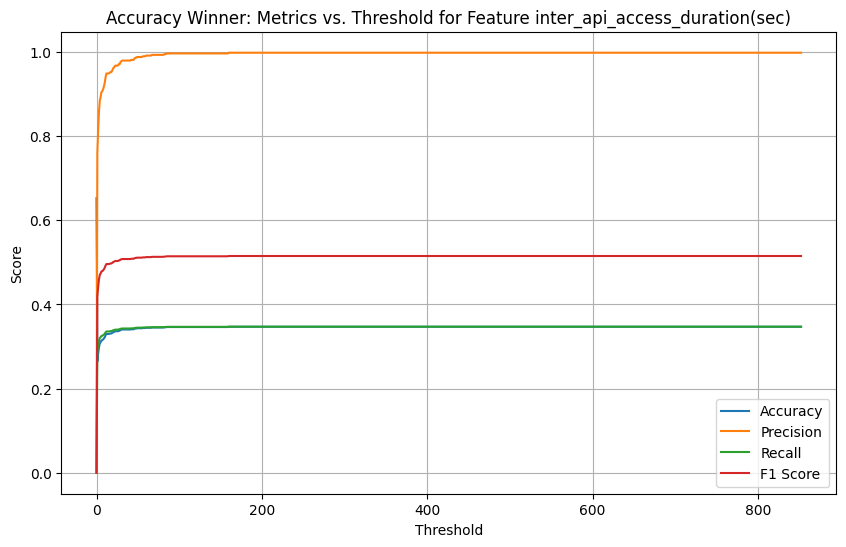

In [13]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

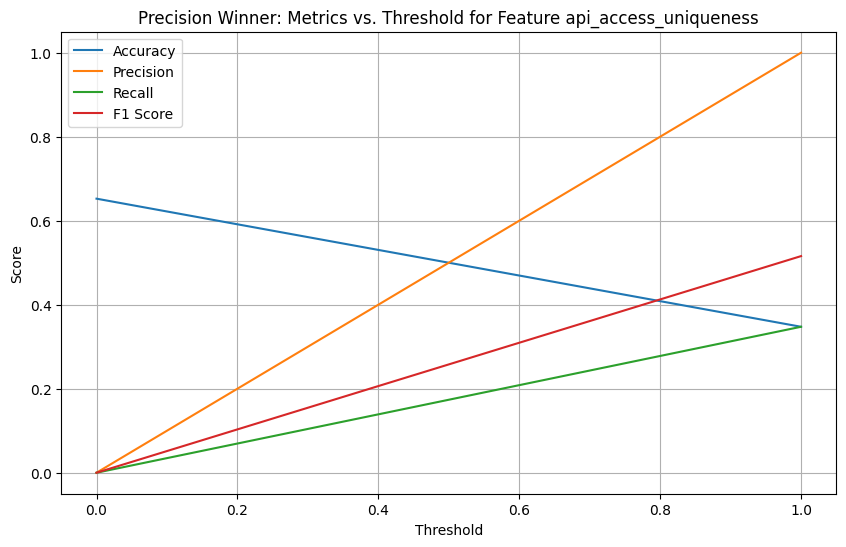

In [14]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

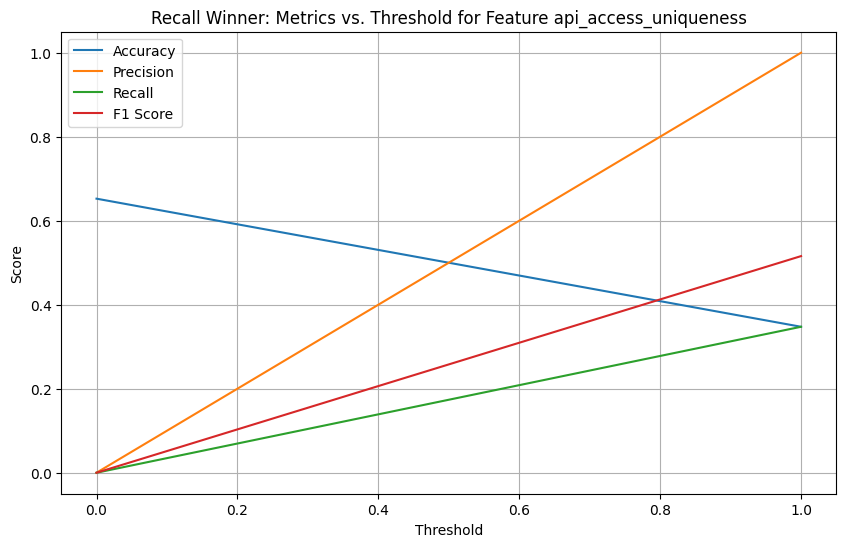

In [15]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

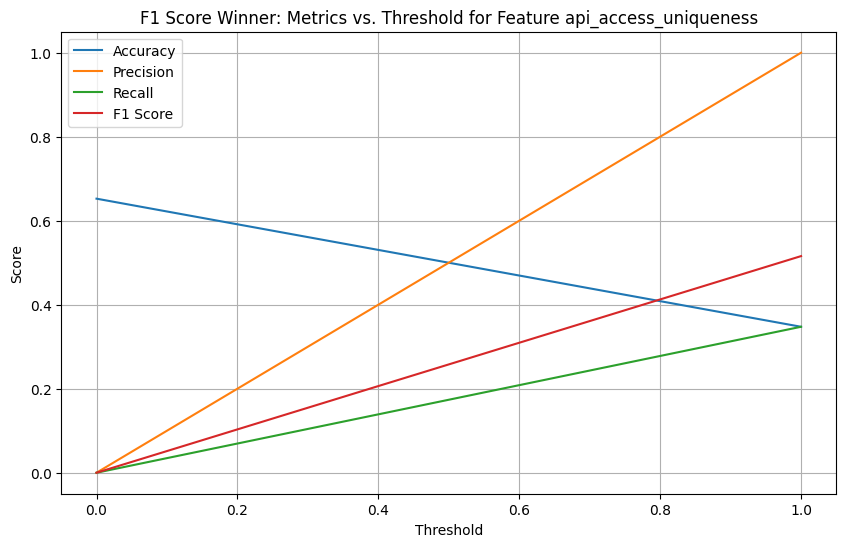

In [16]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

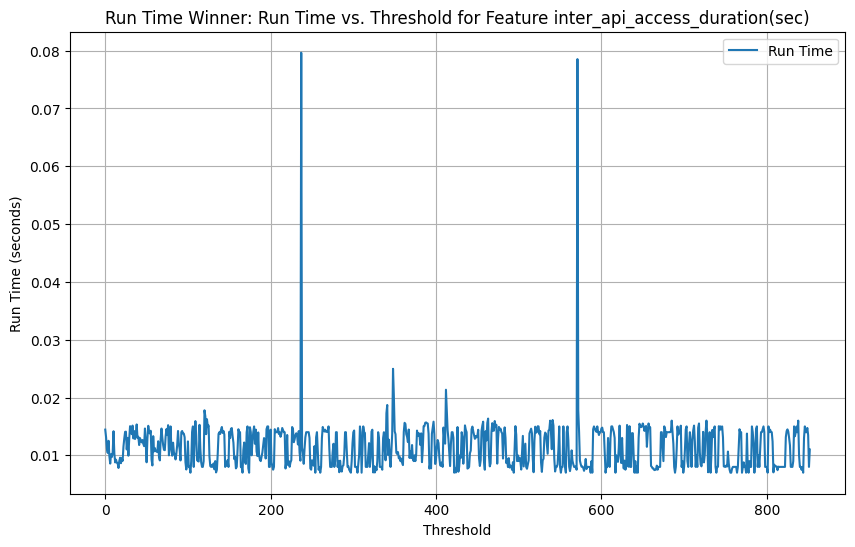

In [17]:
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds, run_time = [], []
    for result in winner_results:
        thresholds.append(result[0][1])
        run_time.append(result[5][0])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)

In [18]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0][0]} dan threshold {winner_precision[0][1]}, menghasilkan precision {winner_precision[1][0]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0][0]} dan threshold {winner_recall[0][1]}, menghasilkan recall {winner_recall[2][0]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0][0]} dan threshold {winner_f1_score[0][1]}, menghasilkan F1-score {winner_f1_score[3][0]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0][0]} dan threshold {winner_accuracy[0][1]}, menghasilkan akurasi {winner_accuracy[4][0]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0][0]} dan threshold {winner_run_time[0][1]}, dengan waktu running {winner_run_time[5][0]} detik.")

Precision terbaik dicapai dengan fitur api_access_uniqueness dan threshold 1, menghasilkan precision 1.0.
Recall terbaik dicapai dengan fitur api_access_uniqueness dan threshold 1, menghasilkan recall 0.34749262536873154.
F1-score terbaik dicapai dengan fitur api_access_uniqueness dan threshold 1, menghasilkan F1-score 0.5157618213660244.
Akurasi terbaik dicapai dengan fitur inter_api_access_duration(sec) dan threshold 0, menghasilkan akurasi 0.6525073746312684.
Waktu running tercepat dicapai dengan fitur inter_api_access_duration(sec) dan threshold 770, dengan waktu running 0.006994962692260742 detik.
